In [45]:
import numpy as np
import copy

class LinearRegressor:
    """
    Extended Linear Regression model with support for categorical variables and gradient descent fitting.
    """

    def __init__(self, kernel = False):
        self.coefficients = None
        self.intercept = None
        self.kernel = kernel
        self.Z = None
    """
    This next "fit" function is a general function that either calls the *fit_multiple* code that
    you wrote last week, or calls a new method, called *fit_gradient_descent*, not implemented (yet)
    """
    def fit(self, X, y, method="least_squares", learning_rate=0.01, iterations=1000, mini_batch_size = None, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array).
            y (np.ndarray): Dependent variable data (1D array).
            method (str): method to train linear regression coefficients. 
                          It may be "least_squares" or "gradient_descent".
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        if method not in ["least_squares", "gradient_descent", "adam"]:
            raise ValueError(f"Method {method} not available for training linear regression.")
        if np.ndim(X) == 1:
            X = X.reshape(-1, 1)
        
        X_with_bias = np.insert(X, 0, 1, axis=1)  # Adding a column of ones for intercept

        if method == "least_squares":
            self.fit_multiple(X_with_bias, y)
        elif method == "gradient_descent":
            self.fit_gradient_descent(X_with_bias, y, learning_rate, iterations, mini_batch_size)
        elif method == "adam":
            self.fit_adam_optimization(X_with_bias, y, learning_rate, iterations, mini_batch_size, beta1, beta2, epsilon)
    
    def fit_multiple(self, X, y):
        """
        Fit the model using multiple linear regression (more than one independent variable).

        This method applies the matrix approach to calculate the coefficients for
        multiple linear regression.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        # This code replaces the code you had last week. 
        # If you want, feel free to paste here your code! 
        
        X_transpose = np.transpose(X)
        X_transpose_dot_X = X_transpose.dot(X)
        inverse_X_transpose_dot_X = np.linalg.inv(X_transpose_dot_X)
        X_transpose_dot_y = X_transpose.dot(y)

        coefficients = inverse_X_transpose_dot_X.dot(X_transpose_dot_y)
        
        
        # Store the intercept and the coefficients of the model
        self.intercept = coefficients[0]
        self.coefficients = coefficients[1:]

    def kernel_func(self, x, z):
        return np.exp(- np.linalg.norm(x - z, 2) / (2*0.001))

    def create_kernel(self, X) -> None:
        self.X = X
        n = X.shape[0]
        self.Z = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                self.Z[i, j] = self.kernel_func(X[i], X[j])  # self.X[i].T @ self.X[j]
                if i != j:
                    self.Z[j, i] = self.Z[i, j]

    def fit_gradient_descent(self, X, y, learning_rate=0.01, iterations=1000,mini_batch_size = 64):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        
        # Initialize the parameters to very small values (close to 0)
        m = len(y)
        if mini_batch_size is None or mini_batch_size > m:
            mini_batch_size = m

        if self.kernel:
            self.X = X
            self.create_kernel(X)
            self.alphas = np.random.rand(X.shape[0]) * 0.01

        self.coefficients = np.random.rand(X.shape[1] - 1) * 0.01  # Small random numbers
        self.intercept = np.random.rand() * 0.01

        losses = []
        coeffs = []
        for epoch in range(iterations):
            if not self.kernel:
                for mini_batch_X, mini_batch_y in self.get_minibatches(X, y, mini_batch_size):
                    coeffs.append((copy.deepcopy(self.coefficients), copy.deepcopy(self.intercept) if isinstance(self.intercept, list) else [self.intercept]))

                    if not self.kernel:
                        predictions =  mini_batch_X.dot(np.insert(self.coefficients, 0, self.intercept))

                        error = predictions - mini_batch_y
                        
                        gradient = (2 * np.matmul(mini_batch_X.T, predictions) - 2 * np.matmul(mini_batch_X.T, mini_batch_y))/m

                        self.intercept -= learning_rate * gradient[0]
                        self.coefficients -= learning_rate * gradient[1:]

                if epoch % 10 == 0:

                    mse = np.sum(np.matmul(error.T, error))/m
                    losses.append(mse)

            else:
                # With kernel
                n = len(self.alphas)
                new_alphas = np.zeros_like(self.alphas)
                for k in range(0, n):
                    grad = 0
                    for j in range(0, n):
                        suma = 0
                        for i in range(0, n):
                            suma += self.alphas[i] * self.Z[i, j]
                        grad += (y[j] - suma) * self.Z[k,j]

                    new_alphas[k] = self.alphas[k] - learning_rate * (-1/n) * grad

                self.alphas = new_alphas.copy()
            



    def fit_adam_optimization(self, X, y, learning_rate=0.01, iterations=1000, mini_batch_size = None, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        """
        Fit the model using either normal equation or gradient descent.

        Args:
            X (np.ndarray): Independent variable data (2D array), with bias.
            y (np.ndarray): Dependent variable data (1D array).
            learning_rate (float): Learning rate for gradient descent.
            iterations (int): Number of iterations for gradient descent.

        Returns:
            None: Modifies the model's coefficients and intercept in-place.
        """
        
        # Initialize the parameters to very small values (close to 0)
        m = len(y)
        if mini_batch_size is None or mini_batch_size > m:
            mini_batch_size = m


        self.coefficients = np.random.rand(X.shape[1] - 1) * 0.01  # Small random numbers
        self.intercept = np.random.rand() * 0.01


        losses = []
        V_dw = 0
        S_dw = 0

        V_db = 0
        S_db = 0

        coeffs = []
        for epoch in range(iterations):
            for mini_batch_X, mini_batch_y in self.get_minibatches(X, y, mini_batch_size):
                coeffs.append((copy.deepcopy(self.coefficients), copy.deepcopy(self.intercept) if isinstance(self.intercept, list) else [self.intercept]))

                predictions = mini_batch_X.dot(np.insert(self.coefficients, 0, self.intercept))

                error = predictions - mini_batch_y


                gradient = (2 * np.matmul(mini_batch_X.T, predictions) - 2 * np.matmul(mini_batch_X.T, mini_batch_y))/m

                db = gradient[0]
                dw = gradient[1:]

                V_dw = beta1 * V_dw + (1 - beta1) * dw
                V_db = beta1 * V_db + (1 - beta1) * db

                S_dw = beta2 * S_dw + (1 - beta2) * dw**2
                S_db = beta2 * S_db + (1 - beta2) * db**2

                V_corrected_dw = V_dw / (1 - beta1**(epoch + 1))
                V_corrected_db = V_db / (1 - beta1**(epoch + 1))

                S_corrected_dw = S_dw / (1 - beta2**(epoch + 1))
                S_corrected_db = S_db / (1 - beta2**(epoch + 1))

                self.intercept -= learning_rate * V_corrected_db / (np.sqrt(S_corrected_db) + epsilon)
                self.coefficients -= learning_rate * V_corrected_dw / (np.sqrt(S_corrected_dw) + epsilon)

            if epoch % 10 == 0:
                mse = np.sum(np.matmul(error.T, error))/m
                losses.append(mse)
                # print(f"Epoch {epoch}: MSE = {mse}")
        
        # plot_losses(losses, "Adam", mini_batch_size)
        # if len(self.coefficients) == 1:
            # plot_contour(X, y, coeffs, "Adam", mini_batch_size,  w_range=[-3, 3, 0.1], b_range=[-3, 3, 0.1])

    
    def predict(self, X):
        """
        Predict the dependent variable values using the fitted model.

        Args:
            X (np.ndarray): Independent variable data (1D or 2D array).
            fit (bool): Flag to indicate if fit was done.

        Returns:
            np.ndarray: Predicted values of the dependent variable.

        Raises:
            ValueError: If the model is not yet fitted.
        """
        
        if self.coefficients is None or self.intercept is None:
            raise ValueError("Model is not yet fitted")
        
        if np.ndim(X) == 1:
            X = X.reshape(-1, 1)


        X_with_bias = np.insert(X, 0, 1, axis=1)
        if self.kernel:
            target_ys = np.zeros(X.shape[0])
            for k in range(X.shape[0]):
                suma = 0
                for i in range(len(self.alphas)):
                    suma += self.alphas[i] * self.kernel_func(self.X[i], X_with_bias[k])
                target_ys[k] = suma
            return target_ys


        return X_with_bias.dot(np.insert(self.coefficients, 0, self.intercept))
    
    def get_minibatches(self, X, y, mini_batch_size = 64):
        m = X.shape[0]
        mini_batches = []

        permutation = np.random.permutation(m)
        X_shuffled = X[permutation, :]
        y_shuffled = y[permutation]

        num_complete_minibatches = m // mini_batch_size
        for k in range(num_complete_minibatches):
            mini_batch_X = X_shuffled[k * mini_batch_size: (k+1)*mini_batch_size, :]
            mini_batch_y = y_shuffled[k * mini_batch_size: (k+1)*mini_batch_size]

            mini_batches.append((mini_batch_X, mini_batch_y))

        if m % mini_batch_size != 0:
            mini_batch_X = X_shuffled[num_complete_minibatches*mini_batch_size:, :]
            mini_batch_y = y_shuffled[num_complete_minibatches*mini_batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_y))

        return mini_batches

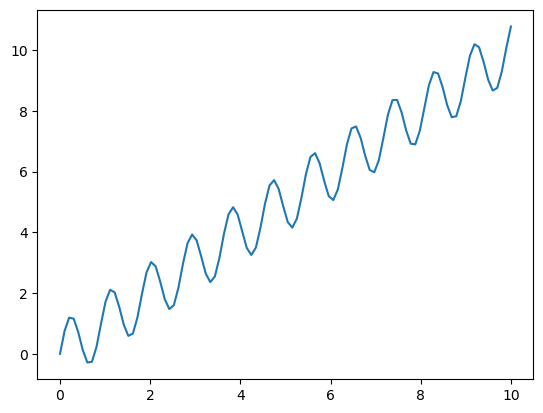

In [46]:
from matplotlib import pyplot as plt


x = np.linspace(0, 10, 100)
y = np.sin(x*7) + x
plt.plot(x, y)

In [50]:
lr = LinearRegressor(True)
lr.fit(x, y, method = "gradient_descent", learning_rate=0.5, iterations=1000)

In [51]:
preds = lr.predict(x)

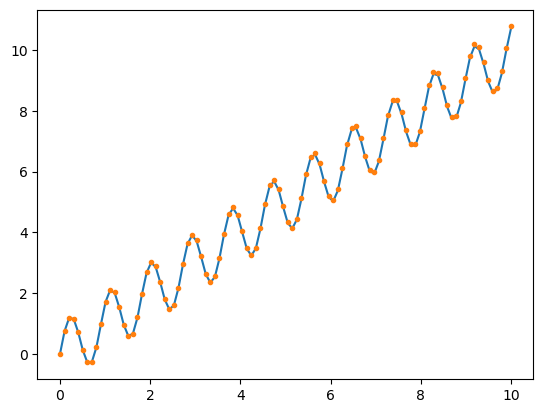

In [52]:
plt.plot(x, preds)
plt.plot(x, y, ".")